# TP - Sentiment Analysis

- Data augmentation
- Use of TF-IDF
- Pycaret models
- Added Neural networks (MLP Classifier)
- Tested tuning, bagging, boosting, blend,...
- Save best model with TF-IDF
- ONNX model conversion

**Final experiment with pycaret: from this we obtain the last and final model with TF-IDF**




## Data Augmentation

- Execute before install pycaret!

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
# "Mount" do Google Drive

drive.mount('/content/drive', force_remount=True)
initial_df = pd.read_csv('/content/drive/MyDrive/sentiment_analysis_exp2.csv')

initial_df

Mounted at /content/drive


Phrase    Target
0     always experience gf gone first like oh cool m...   Neutral
1     right people maybe wont kill feel isolated lon...  Negative
2              know youre lonely come promise take care  Positive
3                            give boost lonely she28ric  Positive
4                                    getting lonely top  Negative
...                                                 ...       ...
2502  certainly another radar see lonely eyes follow...   Neutral
2503  69 girls always grow overnight meeting people ...   Neutral
2504  beauty power antiphons come come emmanuel rans...   Neutral
2505                                rianbow gang hereee   Neutral
2506  article really nails right wing media people k...   Neutral

[2507 rows x 2 columns]

In [ ]:
# Pre-processing steps to fix target 

for i, value in enumerate(initial_df['Target']):
  initial_df['Target'][i] = value.strip()
  if value == 'Nuetral':
    initial_df['Target'][i] = 'Neutral'

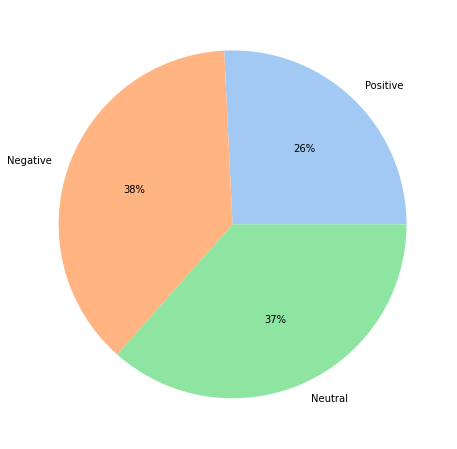

In [ ]:
# Class distribution

countPositives = initial_df[initial_df.Target == 'Positive'].Target.count()
countNegatives = initial_df[initial_df.Target == 'Negative'].Target.count()
countNeutral = initial_df[initial_df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

**From this data we will separate an external validation set and we will only augment the train/test set!**

In [ ]:
df = initial_df.sample(frac=0.95, random_state=786)
data_unseen = initial_df.drop(df.index)

print('Data for Modeling: ' + str(df.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (2382, 2)
Unseen Data For Predictions (125, 2)


**We need to augment dataset in a way that will have all three classes balanced**

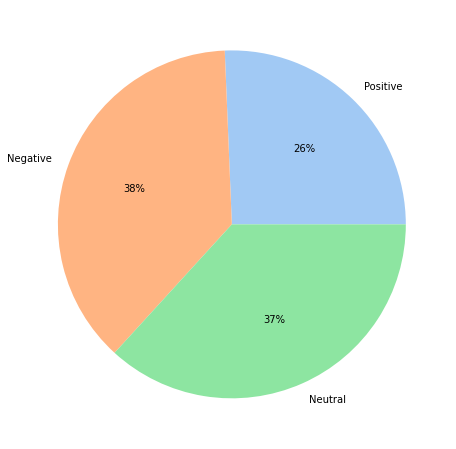

In [ ]:
# Class distribution (after validation set created)

countPositives = df[df.Target == 'Positive'].Target.count()
countNegatives = df[df.Target == 'Negative'].Target.count()
countNeutral = df[df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
# Count for each class
# We need about 260 positive instances to balance dataset

df['Target'].value_counts()

Negative    895
Neutral     876
Positive    611
Name: Target, dtype: int64

In [ ]:
!pip install numpy requests nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 12.8 MB/s eta 0:00:00
ERROR: Operation cancelled by user


In [ ]:
!pip install nltk>=3.4.5

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
#Synonyms augmenter - it will create new phrases generate phrases with the same meaning but other words (synonyms)

aug = naw.SynonymAug(aug_src='wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Balance Dataset

pos_df = df.loc[df['Target'] == 'Positive']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n != 260:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


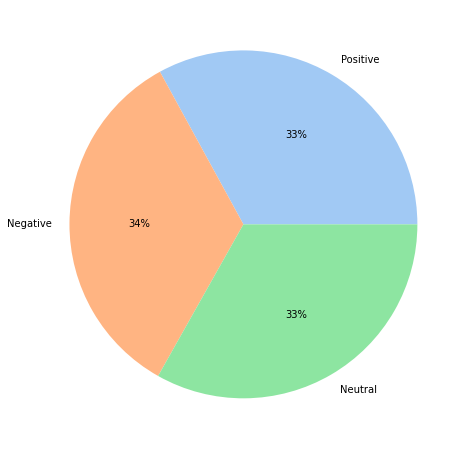

In [ ]:
# Class distribution (after balance with augmentation)

countPositives = df[df.Target == 'Positive'].Target.count()
countNegatives = df[df.Target == 'Negative'].Target.count()
countNeutral = df[df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
df['Target'].value_counts()

Negative    895
Neutral     876
Positive    871
Name: Target, dtype: int64

**Now we need more data so we will try to almost duplicate the classes instances using augmentation**

- 800 new instances for every class to maintain balance

In [ ]:
# Positive class augmentation

pos_df = df.loc[df['Target'] == 'Positive']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n != 800:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

In [ ]:
# Negative class augmentation

pos_df = df.loc[df['Target'] == 'Negative']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n != 800:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

In [ ]:
# Neutral class augmentation

pos_df = df.loc[df['Target'] == 'Neutral']
n = 0

for index, row in pos_df.iterrows():
    aug_phrase = aug.augment(row['Phrase'])[0]
    if aug_phrase != row['Phrase'] and n !=800:
        n = n+1
        new_row = {'Phrase':aug_phrase, 'Target':row['Target']}
        df = df.append(new_row, ignore_index=True)

**Check the final dataset distribution and class instances**

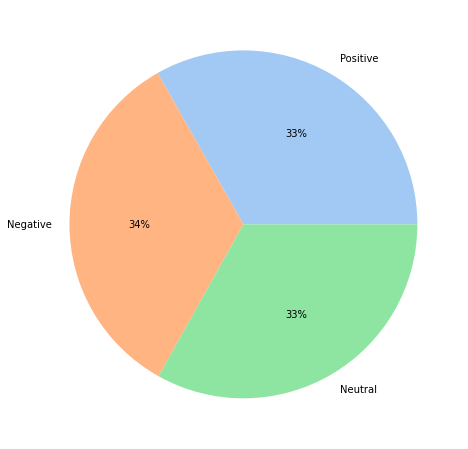

In [ ]:
## Class distribution (final augmented dataset)

countPositives = df[df.Target == 'Positive'].Target.count()
countNegatives = df[df.Target == 'Negative'].Target.count()
countNeutral = df[df.Target == 'Neutral'].Target.count()

data = [countPositives,countNegatives,countNeutral]
labels = ['Positive', 'Negative', 'Neutral']

colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(12, 8))
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
df['Target'].value_counts()

Negative    1695
Positive    1671
Neutral     1666
Name: Target, dtype: int64

In [ ]:
# 5032 instances

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Phrase  5032 non-null   object
 1   Target  5032 non-null   object
dtypes: object(2)
memory usage: 78.8+ KB


In [ ]:
# save both validation and train/test set

df.to_csv('FinalTrainTest.csv',index=False)
data_unseen.to_csv('FinalValSet.csv',index=False)

## Pycaret install and config

In [ ]:
!python --version

Python 3.8.16


In [2]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.7/328.7 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.3 MB/s eta 0:00:00
     

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pycaret.utils import enable_colab
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
enable_colab()

Colab mode enabled.


In [ ]:
df = pd.read_csv('/content/FinalTrainTest.csv')
unseen_data = pd.read_csv('/content/FinalValSet.csv')

In [ ]:
#Join data to apply TF-IDF below

all_df = df.append(unseen_data, ignore_index=True)

In [ ]:
unseen_data

Phrase    Target
0    disappear one day lonely sad students right ab...  Negative
1                             sorry text lot im lonely  Negative
2    lonely yes yes oh god yes trying imagine world...  Positive
3    lonely girl high paying job ceo smith amp sons...  Positive
4    sora ah thank goodness found sorry left lonely...  Positive
..                                                 ...       ...
120  absolutely frustrated went astral finding seei...   Neutral
121  start prescribing spoonfuls nutella instead an...   Neutral
122  rapid acting antidepressants volume 89 advance...   Neutral
123                   antidepressants even makes gravy   Neutral
124                       5 reasons feel relationships   Neutral

[125 rows x 2 columns]

In [ ]:
all_df

Phrase    Target
0     lonely best way focus become stronger man let ...  Positive
1                                    call keith mystery   Neutral
2     long road lonely one still find answers im cho...   Neutral
3     ship chaos escape futile emergency repair resu...  Negative
4                       ladies lonely come keep company   Neutral
...                                                 ...       ...
5152  absolutely frustrated went astral finding seei...   Neutral
5153  start prescribing spoonfuls nutella instead an...   Neutral
5154  rapid acting antidepressants volume 89 advance...   Neutral
5155                   antidepressants even makes gravy   Neutral
5156                       5 reasons feel relationships   Neutral

[5157 rows x 2 columns]

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(all_df.Phrase)
dense = vectors.todense()

all_df['vectorTdfIdf'] = dense.tolist()

In [ ]:
print(vectorizer.get_feature_names())

['000', '001', '02', '10', '100', '100x', '11', '12', '125', '13', '1312', '14', '145', '15', '19', '1950s', '1970s', '1971', '20', '2006', '2011', '2013', '2014', '2015', '2017', '2018', '2019', '2020', '2021', '2022', '20s', '21', '22', '223', '23', '23th', '24', '25', '253days', '258', '263', '273', '2d', '2km', '2nd', '30', '300', '30pm', '30s', '33', '333', '35', '37', '3cmi0ko', '3days', '3l', '40', '40s', '42', '43', '4424', '45', '4929', '4am', '4ever', '4koma', '4th', '50', '504', '512', '663', '67', '68', '69', '6v38pk0', '70', '70k', '75', '79', '7am', '7p', '80', '800', '82', '8255', '83', '85', '86', '89', '8th', '90', '90s', '911', '92', '947', '95', '99', 'a3', 'aaaaaalwaysssss', 'aaaaah', 'aaaah', 'aaron', 'aback', 'abandon', 'abandoned', 'abash', 'abbey', 'abbreviate', 'abhorrent', 'ability', 'abject', 'ablactate', 'able', 'abode', 'abominable', 'abortion', 'about', 'aboveboard', 'absence', 'absolute', 'absolutely', 'absolve', 'abt', 'abundant', 'abuse', 'abusers', 'ab

In [ ]:
df_final = pd.DataFrame(data = dense.tolist(), columns = vectorizer.get_feature_names())
df_final['Target'] = all_df.Target

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5157 entries, 0 to 5156
Columns: 8110 entries, 000 to Target
dtypes: float64(8109), object(1)
memory usage: 319.1+ MB


In [ ]:
from pycaret.classification import *

In [ ]:
df_final['Target'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [ ]:
df_final

000  001   02   10  100  100x   11   12  125   13  1312   14  145   15  \
0     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...   ...  ...  ...  ...  ...   ...  ...  ...  ...   
5152  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5153  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5154  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5155  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5156  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   

       19  1950s  1970s  1971   20  2006  2011  2013  2014  2015  2017  2018  \
0     0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1     0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2     0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3     0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4     0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
...   ...    ...    ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   
5152  0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5153  0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5154  0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5155  0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5156  0.0    0.0    0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

      2019  2020  2021  2022  20s   21   22  223   23  23th   24   25  \
0      0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
1      0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
2      0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
3      0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
4      0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
...    ...   ...   ...   ...  ...  ...  ...  ...  ...   ...  ...  ...   
5152   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
5153   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
5154   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
5155   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
5156   0.0   0.0   0.0   0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   

      253days  258  263  273   2d  2km  2nd   30  300  30pm  30s   33  333  \
0         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
2         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
3         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
4         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...  ...  ...   
5152      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5153      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5154      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5155      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   
5156      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0   

       35   37   3cmi0ko  3days   3l   40  40s   42   43  4424   45  4929  \
0     0.0  0.0  0.000000    0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
1     0.0  0.0  0.000000    0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   0.0   
2     0.0  0.0  0.000000    0.0  0.0  0

In [ ]:
df = df_final.loc[:'5031']
unseen_data = df_final.loc['5032':]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Columns: 8110 entries, 000 to Target
dtypes: float64(8109), object(1)
memory usage: 311.4+ MB


## Classification with PyCaret

In [ ]:
# 70/30 - train and test split by default

exp_1 = setup(data=df, target='Target', remove_perfect_collinearity=False, numeric_features=df.drop(['Target'], axis=1).columns.tolist())

Description  \
0                               session_id   
1                                   Target   
2                              Target Type   
3                            Label Encoded   
4                            Original Data   
5                           Missing Values   
6                         Numeric Features   
7                     Categorical Features   
8                         Ordinal Features   
9                High Cardinality Features   
10                 High Cardinality Method   
11                   Transformed Train Set   
12                    Transformed Test Set   
13                      Shuffle Train-Test   
14                     Stratify Train-Test   
15                          Fold Generator   
16                             Fold Number   
17                                CPU Jobs   
18                                 Use GPU   
19                          Log Experiment   
20                         Experiment Name   
21                                     USI   
22                         Imputation Type   
23          Iterative Imputation Iteration   
24                         Numeric Imputer   
25      Iterative Imputation Numeric Model   
26                     Categorical Imputer   
27  Iterative Imputation Categorical Model   
28           Unknown Categoricals Handling   
29                               Normalize   
30                        Normalize Method   
31                          Transformation   
32                   Transformation Method   
33                                     PCA   
34                              PCA Method   
35                          PCA Components   
36                     Ignore Low Variance   
37                     Combine Rare Levels   
38                    Rare Level Threshold   
39                         Numeric Binning   
40                         Remove Outliers   
41                      Outliers Threshold   
42                Remove Multicollinearity   
43             Multicollinearity Threshold   
44             Remove Perfect Collinearity   
45                              Clustering   
46                    Clustering Iteration   
47                     Polynomial Features   
48                       Polynomial Degree   
49                    Trignometry Features   
50                    Polynomial Threshold   
51                          Group Features   
52                       Feature Selection   
53                Feature Selection Method   
54            Features Selection Threshold   
55                     Feature Interaction   
56                           Feature Ratio   
57                   Interaction Threshold   
58                           Fix Imbalance   
59                    Fix Imbalance Method   

                                   Value  
0                                   3492  
1                                 Target  
2                             Multiclass  
3   Negative: 0, Neutral: 1, Positive: 2  
4                           (5032, 8110)  
5                                  False  
6                                   8109  
7                                      0  
8                                  False  
9                                  False  
10                                  None  
11                          (3522, 8109)  
12                          (1510, 8109)  
13                                  True  
14                                 False  
15                       StratifiedKFold  
16                                    10  
17                                    -1  
18                                 False  
19                                 False  
20                      clf-default-name  
21                                  9d4a  
22                                simple  
23                                  None  
24                                  mean  
25                                  None  
26                              constant  
27                  

INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['000', '001', '02',
                                                          '10', '100', '100x',
                                                          '11', '12', '125',
                                                          '13', '1312', '14',
                                                          '145', '15', '19',
                                                          '1950s', '1970s',
                                                          '1971', '20', '2006',
                                

In [ ]:
top3 = compare_models(n_select = 3)

Model  Accuracy     AUC  Recall   Prec.  \
et                 Extra Trees Classifier    0.8291  0.9430  0.8289  0.8330   
svm                   SVM - Linear Kernel    0.8205  0.0000  0.8206  0.8215   
ridge                    Ridge Classifier    0.8018  0.0000  0.8018  0.8023   
rf               Random Forest Classifier    0.7828  0.9184  0.7826  0.7883   
lr                    Logistic Regression    0.7510  0.8955  0.7510  0.7518   
nb                            Naive Bayes    0.7334  0.8016  0.7326  0.7480   
lightgbm  Light Gradient Boosting Machine    0.6791  0.8363  0.6792  0.6811   
dt               Decision Tree Classifier    0.6769  0.7574  0.6767  0.6817   
gbc          Gradient Boosting Classifier    0.6408  0.8154  0.6408  0.6446   
knn                K Neighbors Classifier    0.6218  0.8164  0.6207  0.6594   
ada                  Ada Boost Classifier    0.5818  0.7376  0.5820  0.5897   
lda          Linear Discriminant Analysis    0.5608  0.6860  0.5607  0.5682   
qda       Quadratic Discriminant Analysis    0.4157  0.5635  0.4179  0.5205   
dummy                    Dummy Classifier    0.3373  0.5000  0.3333  0.1138   

              F1   Kappa     MCC  TT (Sec)  
et        0.8294  0.7435  0.7450    15.381  
svm       0.8200  0.7308  0.7317     5.641  
ridge     0.8015  0.7027  0.7031     2.098  
rf        0.7832  0.6741  0.6761     9.325  
lr        0.7509  0.6264  0.6268    11.508  
nb        0.7323  0.5997  0.6063     0.638  
lightgbm  0.6793  0.5187  0.5193     1.892  
dt        0.6772  0.5151  0.5169     2.147  
gbc       0.6404  0.4612  0.4628    80.197  
knn       0.6195  0.4319  0.4484    30.142  
ada       0.5798  0.3727  0.3763     7.005  
lda       0.5586  0.3410  0.3441    50.812  
qda       0.3657  0.1265  0.1649    14.493  
dummy     0.1702  0.0000  0.0000     0.092

INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3492, verbose=0,
                     warm_start=False), SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=3492, shuffle=True, tol=0.00

In [ ]:
cmp_results = pull()

In [ ]:
mlp_classifier = create_model('mlp')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8159  0.9366  0.8158  0.8154  0.8154  0.7238  0.7239
1       0.7989  0.9278  0.7986  0.7995  0.7990  0.6983  0.6984
2       0.8295  0.9371  0.8296  0.8301  0.8298  0.7443  0.7444
3       0.7841  0.9207  0.7840  0.7841  0.7836  0.6761  0.6765
4       0.8153  0.9239  0.8153  0.8146  0.8143  0.7230  0.7235
5       0.7699  0.9116  0.7703  0.7691  0.7686  0.6549  0.6556
6       0.8125  0.9377  0.8125  0.8122  0.8122  0.7187  0.7189
7       0.7955  0.9283  0.7952  0.8011  0.7938  0.6931  0.6967
8       0.7727  0.9212  0.7722  0.7742  0.7721  0.6590  0.6602
9       0.7955  0.9319  0.7951  0.7968  0.7949  0.6931  0.6941
Mean    0.7990  0.9277  0.7989  0.7997  0.7984  0.6984  0.6992
Std     0.0186  0.0081  0.0186  0.0184  0.0188  0.0279  0.0276

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=3492, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
INFO:logs:create_model() succesfully completed......................................


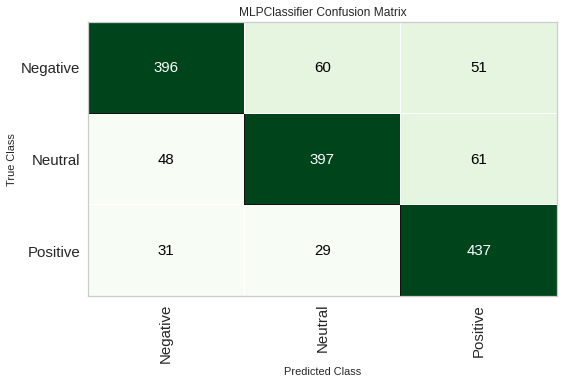

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(mlp_classifier, plot = 'confusion_matrix')

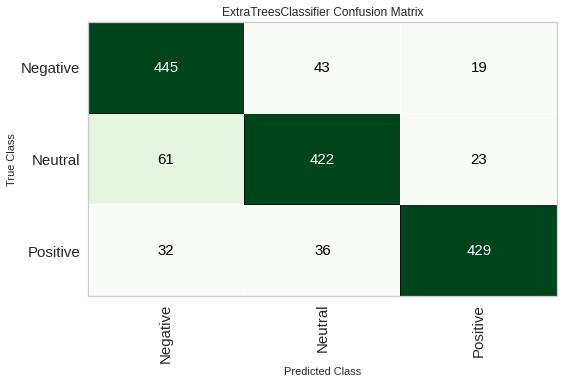

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[0], plot = 'confusion_matrix')

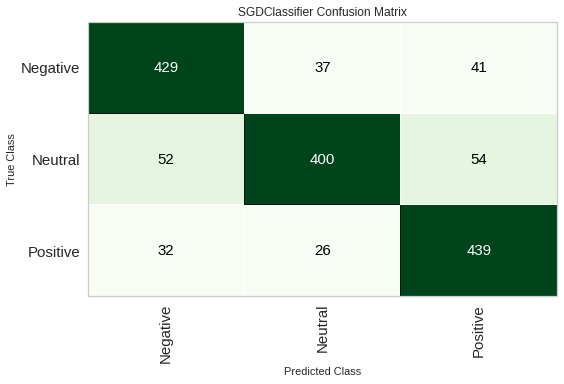

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[1], plot = 'confusion_matrix')

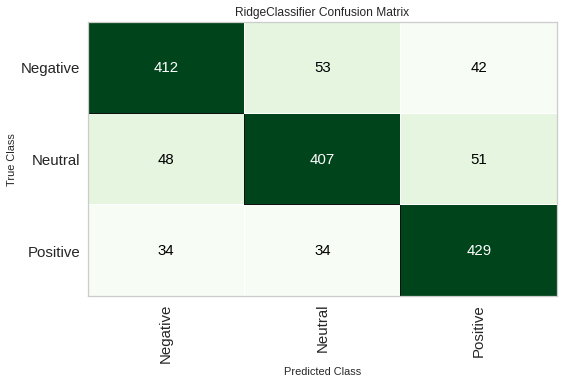

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(top3[2], plot = 'confusion_matrix')

In [ ]:
#Best model test prediction

predict_model(top3[0])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3492, verbose=0,
                     warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Extra Trees Classifier    0.8583  0.9542  0.8583  0.8598  0.8586  0.7874   

      MCC  
0  0.7878

000  001   02   10  100  100x   11   12  125   13  ...  zodiac  zodiacs  \
0     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
2     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
3     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
4     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
...   ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...     ...      ...   
1505  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1506  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1507  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1508  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1509  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   

      zoloft  zona  zone  zzl  zzzzzzzzzz    Target     Label  Score  
0        0.0   0.0   0.0  0.0         0.0  Positive  Positive   0.85  
1        0.0   0.0   0.0  0.0         0.0   Neutral   Neutral   0.85  
2        0.0   0.0   0.0  0.0         0.0  Negative  Negative   0.96  
3        0.0   0.0   0.0  0.0         0.0  Positive  Positive   0.94  
4        0.0   0.0   0.0  0.0         0.0   Neutral   Neutral   0.72  
...      ...   ...   ...  ...         ...       ...       ...    ...  
1505     0.0   0.0   0.0  0.0         0.0  Negative  Negative   0.98  
1506     0.0   0.0   0.0  0.0         0.0  Positive  Positive   0.84  
1507     0.0   0.0   0.0  0.0         0.0  Positive  Positive   0.77  
1508     0.0   0.0   0.0  0.0         0.0   Neutral  Negative   0.60  
1509     0.0   0.0   0.0  0.0         0.0  Negative  Negative   0.88  

[1510 rows x 8112 columns]

In [ ]:
#Second best model test prediction

predict_model(top3[1])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=3492, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model  Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0  SVM - Linear Kernel    0.8397    0    0.84  0.8409  0.8394  0.7596  0.7605

000  001   02   10  100  100x   11   12  125   13  ...  zizzy  zodiac  \
0     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
2     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
3     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
4     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
...   ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...    ...     ...   
1505  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1506  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1507  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1508  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1509  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   

      zodiacs  zoloft  zona  zone  zzl  zzzzzzzzzz    Target     Label  
0         0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
1         0.0     0.0   0.0   0.0  0.0         0.0   Neutral   Neutral  
2         0.0     0.0   0.0   0.0  0.0         0.0  Negative  Negative  
3         0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
4         0.0     0.0   0.0   0.0  0.0         0.0   Neutral   Neutral  
...       ...     ...   ...   ...  ...         ...       ...       ...  
1505      0.0     0.0   0.0   0.0  0.0         0.0  Negative  Negative  
1506      0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
1507      0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
1508      0.0     0.0   0.0   0.0  0.0         0.0   Neutral  Negative  
1509      0.0     0.0   0.0   0.0  0.0         0.0  Negative  Negative  

[1510 rows x 8111 columns]

In [ ]:
#Third best model test prediction

predict_model(top3[2])

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=3492,
                solver='auto', tol=0.001), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


Model  Accuracy  AUC  Recall   Prec.      F1   Kappa   MCC
0  Ridge Classifier    0.8265    0  0.8267  0.8266  0.8263  0.7398  0.74

000  001   02   10  100  100x   11   12  125   13  ...  zizzy  zodiac  \
0     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
2     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
3     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
4     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
...   ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...    ...     ...   
1505  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1506  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1507  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1508  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   
1509  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    0.0     0.0   

      zodiacs  zoloft  zona  zone  zzl  zzzzzzzzzz    Target     Label  
0         0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
1         0.0     0.0   0.0   0.0  0.0         0.0   Neutral   Neutral  
2         0.0     0.0   0.0   0.0  0.0         0.0  Negative  Negative  
3         0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
4         0.0     0.0   0.0   0.0  0.0         0.0   Neutral   Neutral  
...       ...     ...   ...   ...  ...         ...       ...       ...  
1505      0.0     0.0   0.0   0.0  0.0         0.0  Negative  Negative  
1506      0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
1507      0.0     0.0   0.0   0.0  0.0         0.0  Positive  Positive  
1508      0.0     0.0   0.0   0.0  0.0         0.0   Neutral  Negative  
1509      0.0     0.0   0.0   0.0  0.0         0.0  Negative  Negative  

[1510 rows x 8111 columns]

### Tunning parameters

On this case we could not improve the initial result with extra trees classifier

In [ ]:
tune_model(top3[0], n_iter = 50)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6192  0.8108  0.6194  0.6233  0.6186  0.4291  0.4310
1       0.5781  0.7839  0.5780  0.5881  0.5736  0.3673  0.3731
2       0.6219  0.8120  0.6227  0.6244  0.6197  0.4333  0.4358
3       0.6274  0.7997  0.6282  0.6287  0.6264  0.4415  0.4427
4       0.6071  0.7892  0.6072  0.6146  0.6055  0.4108  0.4142
5       0.5852  0.7786  0.5862  0.5999  0.5825  0.3786  0.3858
6       0.6923  0.8672  0.6923  0.6997  0.6925  0.5388  0.5418
7       0.6593  0.8155  0.6595  0.6652  0.6588  0.4893  0.4920
8       0.6346  0.8014  0.6349  0.6358  0.6339  0.4521  0.4531
9       0.6291  0.7994  0.6292  0.6341  0.6302  0.4439  0.4449
Mean    0.6254  0.8058  0.6258  0.6314  0.6242  0.4385  0.4414
Std     0.0316  0.0235  0.0315  0.0302  0.0327  0.0473  0.0463

INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 4
INFO:logs:ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='entropy',
                     max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.001,
                     min_impurity_split=None, min_samples_leaf=6,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=300, n_jobs=-1, oob_score=False,
                     random_state=3501, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='entropy',
                     max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.001,
                     min_impurity_split=None, min_samples_leaf=6,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=300, n_jobs=-1, oob_score=False,
                     random_state=3501, verbose=0, warm_start=False)

In [ ]:
!!pip install optuna

In [ ]:
tune_model(top3[0], n_iter = 50, search_library = 'optuna')

In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.0 MB/s 


In [ ]:
tune_model(top3[0], search_library = 'scikit-optimize')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6384  0.8117  0.6390  0.6464  0.6376  0.4579  0.4613
1       0.6247  0.7819  0.6247  0.6386  0.6232  0.4372  0.4439
2       0.6493  0.8098  0.6506  0.6674  0.6461  0.4746  0.4839
3       0.6274  0.7875  0.6273  0.6398  0.6247  0.4411  0.4480
4       0.6181  0.7989  0.6181  0.6210  0.6135  0.4273  0.4318
5       0.5989  0.7798  0.6003  0.6187  0.5976  0.3994  0.4055
6       0.6593  0.8423  0.6601  0.6734  0.6605  0.4894  0.4937
7       0.6209  0.8062  0.6213  0.6309  0.6221  0.4319  0.4342
8       0.5714  0.7676  0.5721  0.5829  0.5705  0.3577  0.3613
9       0.5934  0.7887  0.5938  0.6155  0.5918  0.3906  0.3985
Mean    0.6202  0.7974  0.6207  0.6334  0.6188  0.4307  0.4362
Std     0.0252  0.0201  0.0252  0.0250  0.0254  0.0377  0.0380

INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 5
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=11, max_features=0.5821566577929185,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=5.948473908760555e-08,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=3, min_weight_fraction_leaf=0.0,
                     n_estimators=245, n_jobs=-1, oob_score=False,
                     random_state=3501, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=11, max_features=0.5821566577929185,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=5.948473908760555e-08,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=3, min_weight_fraction_leaf=0.0,
                     n_estimators=245, n_jobs=-1, oob_score=False,
                     random_state=3501, verbose=0, warm_start=False)

In [ ]:
!pip install tune-sklearn ray[tune]

In [ ]:
tune_model(top3[0], search_library = 'tune-sklearn', search_algorithm = 'hyperopt')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6219  0.7864  0.6226  0.6303  0.6205  0.4334  0.4371
1       0.5808  0.7698  0.5814  0.5982  0.5790  0.3719  0.3788
2       0.6356  0.7996  0.6364  0.6443  0.6349  0.4537  0.4577
3       0.6219  0.7767  0.6222  0.6383  0.6192  0.4331  0.4409
4       0.5852  0.7676  0.5853  0.5884  0.5814  0.3780  0.3816
5       0.5687  0.7604  0.5703  0.5923  0.5660  0.3544  0.3615
6       0.6346  0.8253  0.6358  0.6534  0.6347  0.4526  0.4585
7       0.6071  0.7943  0.6081  0.6295  0.6078  0.4116  0.4175
8       0.5687  0.7593  0.5694  0.5818  0.5677  0.3536  0.3576
9       0.5687  0.7740  0.5692  0.5973  0.5665  0.3537  0.3627
Mean    0.5993  0.7813  0.6001  0.6154  0.5978  0.3996  0.4054
Std     0.0265  0.0194  0.0265  0.0250  0.0271  0.0396  0.0391

INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 6
INFO:logs:ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=10,
                     max_features=0.45738931220637435, max_leaf_nodes=None,
                     max_samples=None,
                     min_impurity_decrease=2.883361564695461e-05,
                     min_impurity_split=None, min_samples_leaf=3,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=179, n_jobs=-1, oob_score=False,
                     random_state=3501, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=10,
                     max_features=0.45738931220637435, max_leaf_nodes=None,
                     max_samples=None,
                     min_impurity_decrease=2.883361564695461e-05,
                     min_impurity_split=None, min_samples_leaf=3,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=179, n_jobs=-1, oob_score=False,
                     random_state=3501, verbose=0, warm_start=False)

### Bagging and Boosting techniques

In [ ]:
bagged_et = ensemble_model(top3[0], method = 'Bagging')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8329  0.9392  0.8326  0.8344  0.8333  0.7493  0.7496
1       0.7836  0.9223  0.7828  0.7840  0.7836  0.6753  0.6755
2       0.8137  0.9399  0.8139  0.8159  0.8141  0.7206  0.7213
3       0.7973  0.9206  0.7972  0.7994  0.7975  0.6959  0.6966
4       0.8214  0.9491  0.8216  0.8235  0.8218  0.7322  0.7328
5       0.7857  0.9019  0.7863  0.7945  0.7867  0.6789  0.6818
6       0.8544  0.9566  0.8544  0.8572  0.8549  0.7817  0.7825
7       0.7912  0.9299  0.7910  0.7966  0.7928  0.6870  0.6879
8       0.7857  0.9290  0.7857  0.7903  0.7863  0.6787  0.6801
9       0.8022  0.9227  0.8021  0.8093  0.8029  0.7034  0.7060
Mean    0.8068  0.9311  0.8068  0.8105  0.8074  0.7103  0.7114
Std     0.0223  0.0149  0.0224  0.0215  0.0223  0.0335  0.0332

INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 7
INFO:logs:BaggingClassifier(base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                      ccp_alpha=0.0,
                                                      class_weight=None,
                                                      criterion='gini',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,

In [ ]:
boosted_et = ensemble_model(top3[0], method = 'Boosting')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8499  0.9498  0.8503  0.8609  0.8512  0.7749  0.7791
1       0.8102  0.9488  0.8107  0.8220  0.8111  0.7155  0.7201
2       0.8438  0.9403  0.8439  0.8491  0.8451  0.7656  0.7667
3       0.8267  0.9413  0.8268  0.8288  0.8272  0.7400  0.7405
4       0.8352  0.9399  0.8355  0.8423  0.8363  0.7529  0.7552
5       0.8239  0.9364  0.8243  0.8350  0.8252  0.7359  0.7401
6       0.8182  0.9292  0.8179  0.8285  0.8193  0.7272  0.7305
7       0.8125  0.9321  0.8130  0.8215  0.8138  0.7189  0.7220
8       0.8324  0.9486  0.8327  0.8406  0.8333  0.7487  0.7518
9       0.8352  0.9427  0.8352  0.8405  0.8359  0.7529  0.7545
Mean    0.8288  0.9409  0.8290  0.8369  0.8298  0.7433  0.7460
Std     0.0123  0.0066  0.0123  0.0117  0.0123  0.0185  0.0181

INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 7
INFO:logs:AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                       

In [ ]:
predict_model(boosted_et)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_sample

Model  Accuracy     AUC  Recall   Prec.      F1   Kappa  \
0  Extra Trees Classifier    0.8543  0.9544  0.8542  0.8613  0.8554  0.7814   

      MCC  
0  0.7837

000  001   02   10  100  100x   11   12  125   13  ...  zodiac  zodiacs  \
0     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
2     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
3     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
4     0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
...   ...  ...  ...  ...  ...   ...  ...  ...  ...  ...  ...     ...      ...   
1505  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1506  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1507  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1508  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   
1509  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...     0.0      0.0   

      zoloft  zona  zone  zzl  zzzzzzzzzz    Target     Label   Score  
0        0.0   0.0   0.0  0.0         0.0  Positive  Positive  0.5072  
1        0.0   0.0   0.0  0.0         0.0   Neutral   Neutral  0.6323  
2        0.0   0.0   0.0  0.0         0.0  Negative  Negative  0.5844  
3        0.0   0.0   0.0  0.0         0.0  Positive  Positive  0.5326  
4        0.0   0.0   0.0  0.0         0.0   Neutral   Neutral  0.5154  
...      ...   ...   ...  ...         ...       ...       ...     ...  
1505     0.0   0.0   0.0  0.0         0.0  Negative  Negative  0.7693  
1506     0.0   0.0   0.0  0.0         0.0  Positive  Positive  0.4942  
1507     0.0   0.0   0.0  0.0         0.0  Positive  Positive  0.6067  
1508     0.0   0.0   0.0  0.0         0.0   Neutral  Negative  0.4038  
1509     0.0   0.0   0.0  0.0         0.0  Negative  Negative  0.4884  

[1510 rows x 8112 columns]

In [ ]:
bm_results = pull()

In [ ]:
#Blend model

blender = blend_models([top3[0],boosted_et])

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.8215  0.9436  0.8215  0.8225  0.8217  0.7323  0.7326
1       0.8300  0.9491  0.8304  0.8336  0.8302  0.7451  0.7465
2       0.8409  0.9409  0.8409  0.8453  0.8421  0.7614  0.7624
3       0.8352  0.9409  0.8352  0.8406  0.8364  0.7529  0.7543
4       0.7926  0.9296  0.7922  0.7943  0.7922  0.6888  0.6899
5       0.8324  0.9564  0.8325  0.8357  0.8327  0.7486  0.7498
6       0.8352  0.9457  0.8349  0.8355  0.8352  0.7528  0.7529
7       0.8352  0.9420  0.8352  0.8391  0.8363  0.7529  0.7536
8       0.8324  0.9485  0.8326  0.8344  0.8326  0.7486  0.7493
9       0.8267  0.9456  0.8262  0.8275  0.8259  0.7400  0.7410
Mean    0.8282  0.9442  0.8282  0.8309  0.8285  0.7423  0.7432
Std     0.0129  0.0066  0.0130  0.0136  0.0133  0.0194  0.0193

INFO:logs:create_model_container: 17
INFO:logs:master_model_container: 17
INFO:logs:display_container: 7
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,

### Save the best model

In [ ]:
# finalize model 

final_model = finalize_model(boosted_et)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samp

In [ ]:
result = predict_model(final_model, data = unseen_data)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_sample

Model  Accuracy     AUC  Recall  Prec.  F1  Kappa  MCC
0  Extra Trees Classifier       0.0  0.7473       0      0   0      0    0

In [ ]:
bm_val_df = pull()

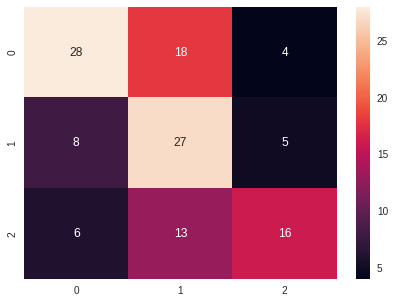

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(result['Target'], result['Label'])
plt.figure(figsize=(7, 5))
df_cm = pd.DataFrame(cm, range(3), range(3))
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 12}) # font size
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef

accuracy_score(result['Target'], result['Label'])

0.568

In [ ]:
precision_score(result['Target'], result['Label'],average='macro')

0.590727969348659

In [ ]:
recall_score(result['Target'], result['Label'],average='macro')

0.564047619047619

In [ ]:
f1_score(result['Target'], result['Label'],average='macro')

0.5643497978901705

In [ ]:
cohen_kappa_score(result['Target'], result['Label'])

0.3465634075508227

In [ ]:
matthews_corrcoef(result['Target'], result['Label'])

0.35502737465100537

In [ ]:
save_model(final_model, 'final_model_tf_idf')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=ExtraTreesClassifier(bootstrap=False,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['000', '001', '02',
                                                           '10', '100', '100x',
                                                           '11', '12', '125',
                                                           '13', '1312', '14',
                                                           '145', '15', '19',
                                                           '1950s', '1970s',
                                                           '1971', '20', '2006',
                                                           '2011', '2013',
                                                         

In [ ]:
cmp_results.to_csv('compare_results_exp5.csv')
bm_results.to_csv('best_model_results_exp5.csv')
bm_val_df.to_csv('best_model_results_val_exp5.csv')

## ONNX Model

In [ ]:
!pip install onnxmltools

In [15]:
!pip install skl2onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pycaret.classification import load_model 

In [14]:
model = load_model('/content/drive/MyDrive/final_model_tf_idf')

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=/content/drive/MyDrive/final_model_tf_idf, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded


In [21]:
model['trained_model']

AdaBoostClassifier(base_estimator=ExtraTreesClassifier(n_jobs=-1,
                                                       random_state=8918),
                   n_estimators=10, random_state=8918)

In [22]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Specify an initial type for the model ( similar to input shape for the model )
initial_type = [ 
    ( 'input_words' , FloatTensorType( [None,8110] ) ) 
]

converted_model = convert_sklearn( model['trained_model'] , initial_types=initial_type )
with open( "sklearn_model.onnx", "wb" ) as f:
    f.write( converted_model.SerializeToString() )